In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [62]:
import positioner as ps
import IPython 
import numpy as np
from matplotlib import pyplot

This notebook presents an estimate of the number of positioner collisions per pointing.

The positioner's geometry is defined from the DESIDoc 8999 v2. Images are taken from the same doc.

There are three types of collisions.

1. Type I: No collision.
2. Type II: The two upper arms (fiber holders) collide
3. Type III: The upper arm of A collides with the body of B.


Example of Type 2 collision

Type II collisions requires resetting the target one of the two positioners in order to avoid the overlap.
This collision is equivalent to say that if one the positioners (A) is placed outsed the inner clear rotational envelope, the fiber cannot be closer than $2$ mm to other fiber.


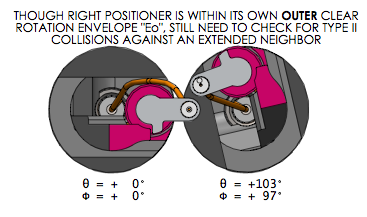

In [2]:
IPython.display.Image("../img/type2_collision.png")

Example of Type 2 collision

For type III collision the condition is less obvious. It will be derived below.

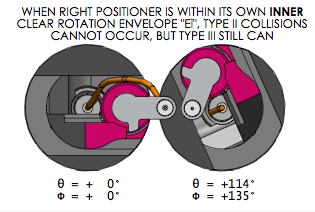

In [3]:
IPython.display.Image("../img/type3_collision.png")

To find the angle between the black line and the axis of symmetry we solve a triangle with known sides.

# Test on poissonian targets

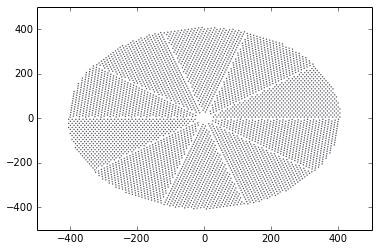

In [104]:
positioner_file = "../../surveyplan/data/pos_on_z1.txt"
positioner_data = np.loadtxt(positioner_file)
x_pos = positioner_data[:,1]
y_pos = positioner_data[:,2]
z_pos = positioner_data[:,3]
pyplot.scatter(x_pos, y_pos, s=0.1)
n_pos = np.size(x_pos)
R1 = 3.0
R2 = 3.0
patrol_radius = R1+R2

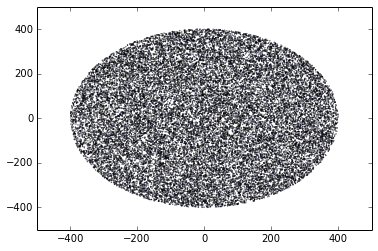

In [117]:
n_targets = n_pos * 5
theta_rand = 2.0 * np.pi * np.random.random(n_targets)
r_rand = 160000.0* np.random.random(n_targets)
x_target = np.sqrt(r_rand) * np.sin(theta_rand)
y_target = np.sqrt(r_rand) * np.cos(theta_rand)
pyplot.scatter(x_target, y_target, s=0.1)

In [118]:
x_on_target = np.zeros(n_pos)
y_on_target = np.zeros(n_pos)
target_available = np.zeros(n_targets)
for i in range(n_pos):
    x_pos_i = x_pos[i]
    y_pos_i = y_pos[i]
    
    distance = np.sqrt((x_target-x_pos_i)**2 + (y_target - y_pos_i)**2)
    reachable = np.where((distance<patrol_radius)&(target_available==0))
    reachable = reachable[0]
    n_reachable = np.size(reachable)
    
    if (n_reachable):
        x_on_target[i] = x_target[reachable[0]]
        y_on_target[i] = y_target[reachable[0]]
        target_available[reachable[0]] = -1
    else:
        x_on_target[i] = x_pos_i
        y_on_target[i] = y_pos_i

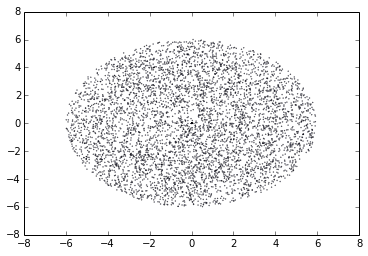

In [119]:
pyplot.scatter(x_on_target-x_pos, y_on_target-y_pos, s=0.1)

In [120]:
#amount on x and y that each fiber has to move to reach the target
x_move = x_on_target - x_pos
y_move = y_on_target - y_pos

#the corresponding Theta and Phi for each positioner
r = np.sqrt(x_move**2 + y_move**2) + 1E-12
cos_alpha = (R2*R2 + R1*R1 - r*r)/(2.0*R2*R1)
cos_beta = (R1*R1 + r*r - R2*R2)/(2.0*R1*r)
cos_gamma = (r*r + R2*R2 - R1*R1)/(2.0*r*R2)
cos_delta = x_move/r

P = cos_alpha.copy()
T = cos_alpha.copy()
P[:] = np.inf
T[:] = np.inf

good = np.where(np.abs(cos_gamma)<=1.0)

T[good] = 2.0*np.pi - np.arccos(cos_beta[good]) - np.arccos(cos_delta[good])
P[good] = np.pi - np.arccos(cos_alpha[good])

positive_y = np.where((y_move>=0.0) & (np.abs(cos_gamma)<=1.0))
T[positive_y] = np.arccos(cos_delta[positive_y]) - np.arccos(cos_beta[positive_y])

P[good] = np.rad2deg(P[good])
T[good] = np.rad2deg(T[good])

In [121]:
pos_list = []
for i in range(n_pos):
    pos_list.append(ps.positioner(offset_x=x_pos[i], offset_y=y_pos[i],Theta=T[i], Phi=P[i]))

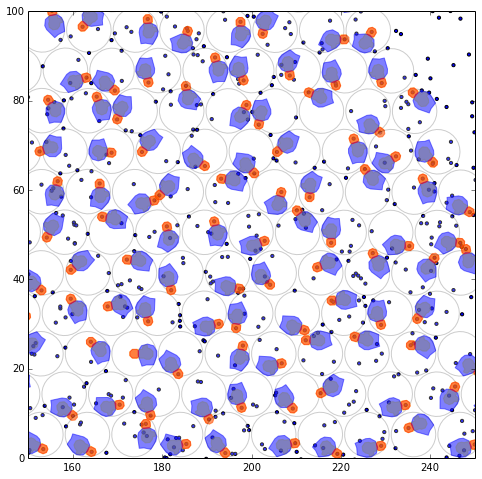

In [122]:
fig, ax = pyplot.subplots(figsize=(8, 8))
ax.set_xlim(150,250)
ax.set_ylim(0,100)
for i in range(200):
    ps.add_plot_positioner(pos_list[i], ax=ax)
pyplot.scatter(x_target, y_target, s=10)

In [123]:
#check for collisions only on the neighboring positioners
n_collision = 0
for i in range(n_pos):
    x_pos_i = x_pos[i]
    y_pos_i = y_pos[i]
    distance = np.sqrt((x_pos-x_pos_i)**2 + (y_pos - y_pos_i)**2)
    reachable = np.where(distance<patrol_radius*2.1)
    reachable = reachable[0]
    n_reachable = np.size(reachable)
    for j in reachable:
        if(i!=j):
            a, b = ps.find_collision_type(pos_list[i], pos_list[j])
            if(a|b):
                n_collision = n_collision + 1   
print n_collision

626


In [124]:
1.0*n_collision/n_pos

0.11946564885496183